In [1]:
import tensorflow as tf
import os
import json
import functools
import pyvista as pv
import numpy as np
from utils import *

2024-10-11 10:43:11.171131: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/xaviern/.conda/envs/cfdMl-clean/lib/python3.10/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/xaviern/.conda/envs/cfdMl-clean/lib/python3.10/site-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(


In [2]:
def plot_graph(data, l=1, plotter=None, node_colors=None):
    
    c = ['r', 'g', 'b', 'm']
    
    p = pv.Plotter() if plotter is None else plotter
    
    # Création d'un PolyData pour les points (nœuds)
    mesh = pv.PolyData()
    
    # Gestion des dimensions des positions
    if data.pos.shape[1] != 3:
        # Ajouter une troisième dimension si nécessaire
        mesh.points = np.concatenate([data.pos.cpu().numpy(), np.full((data.pos.shape[0], 1), l)], axis=1)
    else:
        mesh.points = data.pos.cpu().numpy()

    # Création des lignes pour les arêtes
    edges = data.edge_index.t().cpu().numpy()
    lines = np.hstack([np.full((edges.shape[0], 1), 2), edges]).ravel()
    mesh.lines = lines
    
    
    # Ajout des couleurs au PolyData
    mesh.point_data['values'] = node_colors if node_colors is not None else np.random.randint(0, 255, size=(data.pos.shape[0], 3))
    
    # Ajouter le mesh avec les couleurs des nœuds
    p.add_mesh(mesh, scalars='values', line_width=0.5, point_size=0.3, render_points_as_spheres=True)

    # Si aucun plotter n'a été fourni, on montre la figure
    if plotter is None:
        p.show()

In [3]:
def _parse(proto, meta):
  """Parses a trajectory from tf.Example."""
  feature_lists = {k: tf.io.VarLenFeature(tf.string)
                   for k in meta['field_names']}
  features = tf.io.parse_single_example(proto, feature_lists)
  out = {}
  for key, field in meta['features'].items():
    data = tf.io.decode_raw(features[key].values, getattr(tf, field['dtype']))
    data = tf.reshape(data, field['shape'])
    if field['type'] == 'static':
      data = tf.tile(data, [meta['trajectory_length'], 1, 1])
    elif field['type'] == 'dynamic_varlen':
      length = tf.io.decode_raw(features['length_'+key].values, tf.int32)
      length = tf.reshape(length, [-1])
      data = tf.RaggedTensor.from_row_lengths(data, row_lengths=length)
    elif field['type'] != 'dynamic':
      raise ValueError('invalid data format')
    out[key] = data
  return out

def load_dataset(path, split):
  """Load dataset."""
  with open(os.path.join(path, 'meta.json'), 'r') as fp:
    meta = json.loads(fp.read())
  ds = tf.data.TFRecordDataset(os.path.join(path, split+'.tfrecord'))
  ds = ds.map(functools.partial(_parse, meta=meta), num_parallel_calls=8)
  ds = ds.prefetch(1)
  return ds

In [4]:
train_ds = load_dataset("../../DATA/cylinder_flow", 'train')
val_ds = load_dataset("../../DATA/cylinder_flow", 'valid')
test_ds = load_dataset("../../DATA/cylinder_flow", 'test')

2024-10-11 10:43:19.581850: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
from torch_geometric.data import Data
import torch
from utils import  DelaunayTransform
from torch_geometric.loader import DataLoader


In [33]:
def prepare_dataset_fraction(ds, max: int):
    transform = DelaunayTransform()
    dataset = []
    ds_iter = iter(ds)
    for i in range(max):
        obs = next(ds_iter)
        new_obs = {}
        for key, value in obs.items():
            if 'mesh' in key or 'cells' in key or 'node_type' in key:
                key = key.replace('mesh_', '')
                new_obs[key] = torch.Tensor(value[0].numpy())
            else:
                new_obs["x_" + key] = torch.Tensor(value[0].numpy())
                new_obs["y_" + key] = torch.Tensor(value[-1].numpy())
        surf = torch.Tensor((obs['velocity'][0][:] == 0.0).numpy())
        surf = torch.logical_and(surf[:, 0], surf[:, 1])
        x = torch.cat([new_obs['x_velocity'], new_obs['x_pressure'], surf.unsqueeze(1)], dim=1)
        y = torch.cat([new_obs['y_velocity'], new_obs['y_pressure']], dim=1)
        data = transform(Data(pos=new_obs["pos"], surf=surf, x=x, y=y))
        data = generate_coarse_graphs(data, 3, 4)
        dataset.append(data)
    data_loader = DataLoader(dataset=dataset, batch_size=1)
    return data_loader
train_loader = prepare_dataset_fraction(train_ds, 50)
val_loader = prepare_dataset_fraction(val_ds, 100)
test_loader = prepare_dataset_fraction(test_ds, 100)

In [7]:
import importlib
import utils
importlib.reload(utils)
import my_model_mlp
from utils import *

In [8]:
#plot_graph(generate_coarse_graphs(next(iter(data_loader)), R=3, K=4, visualize=True))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print(device)

cpu


In [24]:
def validate(model, loader, device):
    model.eval()
    loss = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
            loss += torch.nn.functional.mse_loss(out, data.y).item()
    return loss / len(loader)

In [59]:
importlib.reload(my_model_mlp)
import my_model_mlp

In [35]:
model = my_model_mlp.MyMlp(4, 3, device, [64, 64, 8, 64, 64, 64, 8, 64, 64])
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
model = model.to(device)

In [36]:
import matplotlib.pyplot as plt

validation_losses = []
train_losses = []
for epoch in range(30):
    loss_av = 0
    i = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        if torch.isnan(out).any():
            print("Nan")
        loss = torch.nn.functional.mse_loss(out, data.y)
        loss_av += loss.item()
        i += 1
        loss.backward()
        optimizer.step()
    train_losses.append(loss_av/i)
    validation_losses.append(validate(model, val_loader, device))
    print(f"Epoch {epoch} Loss {loss_av/i}")
    print(f"Validation Loss {validation_losses[-1]}")
    



Epoch 0 Loss 0.84418133020401
Validation Loss 1.3253152751922608
Epoch 1 Loss 0.14668883938342334
Validation Loss 0.13084306615404784
Epoch 2 Loss 0.04205139324069023
Validation Loss 0.12872541988734157
Epoch 3 Loss 0.04273102091625333
Validation Loss 0.132262643314898
Epoch 4 Loss 0.03863339313305914
Validation Loss 0.10442624198272825
Epoch 5 Loss 0.03847688127309084
Validation Loss 0.09954734886996448
Epoch 6 Loss 0.036264718007296325
Validation Loss 0.10342729012481869
Epoch 7 Loss 0.039531163927167656
Validation Loss 0.09899433649610728
Epoch 8 Loss 0.0361375748552382
Validation Loss 0.09706775208935142
Epoch 9 Loss 0.03587067340500653
Validation Loss 0.10289456200320274
Epoch 10 Loss 0.03507627615705133
Validation Loss 0.09582493877504021
Epoch 11 Loss 0.03663691052235663
Validation Loss 0.09632491858676076
Epoch 12 Loss 0.03510722758248448
Validation Loss 0.09479183905757964
Epoch 13 Loss 0.034670518860220906
Validation Loss 0.094531583734788
Epoch 14 Loss 0.0346477167122066
Val

In [37]:
validate(model, test_loader, device)

0.07539169426076114

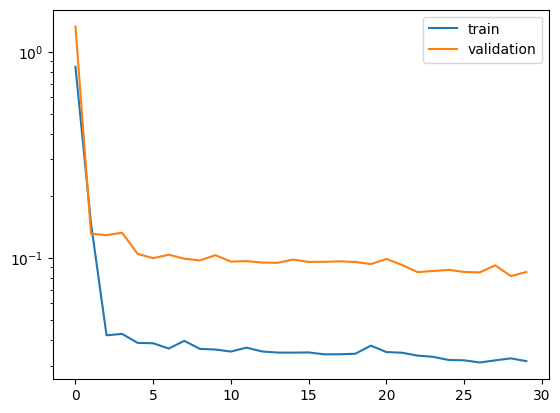

In [41]:
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.legend()
plt.yscale('log')

In [60]:
model_pinn = my_model_mlp.MyMlp(4, 3, device, [64, 64, 8, 64, 64, 64, 8, 64, 64])
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
model_pinn = model_pinn.to(device)

In [73]:
def pinn_loss(out, features):
    
    u = out[:, 0]
    v = out[:, 1]
    p = out[:, 2]
        
    x = features[:, 0]
    y = features[:, 1]
    
    print(out)
    

    rho_inv = 1.0/1.225

    nu = 1.55e-5

    u_x = torch.autograd.grad(out[:, 0], features[:,0], torch.ones_like(out[:, 0]), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, torch.ones_like(v), create_graph=True)[0]
    
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
    
    p_x = torch.autograd.grad(p, x, torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, torch.ones_like(p), create_graph=True)[0]
    
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=False)[0]
    v_yy = torch.autograd.grad(v_y, y, torch.ones_like(v_y), create_graph=False)[0]
    
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=False)[0]
    v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x), create_graph=False)[0]
    
    
    laplace_u = u_xx + v_yy
    
    r1 = u_x + v_y
    
    r2 = u*u_x + v*u_y + p_x*rho_inv - (nu)*(u_xx + u_yy)
    r3 = u*v_x + v*v_y + p_y*rho_inv - (nu)*(v_xx + v_yy)
    x.requires_grad_(False)
    y.requires_grad_(False)

    return torch.mean((r1**2 + r2**2 + r3**2))

In [56]:
data = next(iter(train_loader))
print(data.x.shape)

torch.Size([2678, 4])


In [74]:
import matplotlib.pyplot as plt

validation_losses_pinn = []
pinn_losses = []
train_losses_pinn = []
for epoch in range(30):
    loss_av_pinn = 0
    pinn_loss_av = 0
    i = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        _in = data.x.clone()[:data.y.shape[0], :]
        _in.requires_grad = True
        out = model_pinn(_in)
        if torch.isnan(out).any():
            print("Nan")
        print(_in)
        pinn_loss_value = pinn_loss(out, _in)
        loss = torch.nn.functional.mse_loss(out, data.y) + pinn_loss_value
        loss_av_pinn += loss.item()
        pinn_loss_av += pinn_loss_value.item()
        i += 1
        loss.backward()
        optimizer.step()
    train_losses_pinn.append(loss_av_pinn/i)
    validation_losses_pinn.append(validate(model_pinn, val_loader, device))
    print(f"Epoch {epoch} Loss {loss_av_pinn/i} PINN {pinn_loss_av/i}")
    print(f"Validation Loss {validation_losses_pinn[-1]}")
    


tensor([[ 0.0779,  0.0000,  0.8122,  0.0000],
        [ 0.0394,  0.0000,  0.8222,  0.0000],
        [ 0.1001, -0.0809,  0.8457,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0041,  1.0000],
        [ 0.2780, -0.0038,  0.0232,  0.0000],
        [ 0.0000,  0.0000,  0.0286,  1.0000]], requires_grad=True)
tensor([[-0.6601,  0.9579, -0.2719],
        [ 1.0496, -0.6177,  0.2818],
        [-0.6601,  0.4306,  0.2677],
        ...,
        [-0.6601, -0.6114,  0.0316],
        [-0.6601, -0.2476,  1.3532],
        [ 2.5123, -0.6177,  1.8597]], grad_fn=<PermuteBackward0>)


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.